<a href="https://colab.research.google.com/github/vijaya-praveena/Internship/blob/main/SocialMedia_Engagement_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas matplotlib seaborn wordcloud textblob openpyxl scikit-learn
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from google.colab import files
uploaded = files.upload()

Saving socialmedia_analysis.csv to socialmedia_analysis (1).csv


In [19]:
import pandas as pd
import numpy as np

# Load from spreadsheet
file_path = 'socialmedia_analysis.csv'  # or .csv
df = pd.read_csv(file_path)  # or pd.read_csv()

# Preview
print(df.columns)
df.dropna(subset=['text_content'], inplace=True)  # Clean missing posts
df.head()

Index(['post_id', 'timestamp', 'day_of_week', 'platform', 'user_id',
       'location', 'language', 'text_content', 'hashtags', 'mentions',
       'keywords', 'topic_category', 'sentiment_score', 'sentiment_label',
       'emotion_type', 'toxicity_score', 'likes_count', 'shares_count',
       'comments_count', 'impressions', 'engagement_rate', 'brand_name',
       'product_name', 'campaign_name', 'campaign_phase',
       'user_past_sentiment_avg', 'user_engagement_growth',
       'buzz_change_rate'],
      dtype='object')


,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


In [21]:
# Drop missing posts
df = df.dropna(subset=['text_content'])

# Fill missing engagement metrics
df[['likes_count', 'shares_count', 'comments_count']] = df[['likes_count', 'shares_count', 'comments_count']].fillna(0)

# Ensure numeric
df[['likes_count', 'shares_count', 'comments_count']] = df[['likes_count', 'shares_count', 'comments_count']].astype(int)

In [22]:
from textblob import TextBlob

df['Polarity'] = df['text_content'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment'] = df['Polarity'].apply(lambda p: 'positive' if p > 0 else 'negative' if p < 0 else 'neutral')


In [24]:
df['Engagement_Score'] = df['likes_count'] + 2 * df['shares_count'] + 1.5 * df['comments_count']

# Label engagement level
def classify_engagement(score):
    if score > df['Engagement_Score'].quantile(0.75):
        return 'High'
    elif score > df['Engagement_Score'].quantile(0.4):
        return 'Medium'
    else:
        return 'Low'

df['Engagement_Level'] = df['Engagement_Score'].apply(classify_engagement)
df[['text_content', 'Engagement_Level']].head()

,text_content,Engagement_Level
0,Just tried the Chromebook from Google. Best pu...,Medium
1,Just saw an ad for Microsoft Surface Laptop du...,Low
2,What's your opinion about Nike's Epic React? ...,Medium
3,Bummed out with my new Diet Pepsi from Pepsi! ...,Low
4,Just tried the Corolla from Toyota. Absolutely...,Medium


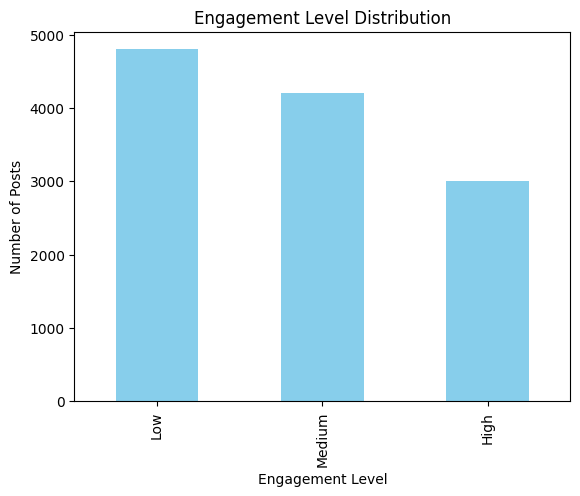

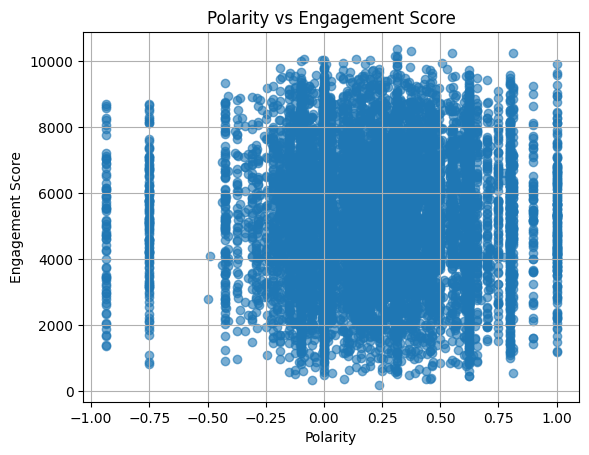

In [26]:
import matplotlib.pyplot as plt

# Engagement level distribution
df['Engagement_Level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Engagement Level Distribution')
plt.xlabel('Engagement Level')
plt.ylabel('Number of Posts')
plt.show()

# Polarity vs Score
plt.scatter(df['Polarity'], df['Engagement_Score'], alpha=0.6)
plt.title('Polarity vs Engagement Score')
plt.xlabel('Polarity')
plt.ylabel('Engagement Score')
plt.grid(True)
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Encode sentiment
df['Sentiment_Code'] = LabelEncoder().fit_transform(df['Sentiment'])

# Features and target
features = df[['likes_count', 'shares_count', 'comments_count', 'Polarity', 'Sentiment_Code']]
target = df['Engagement_Level']

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        High       0.99      0.97      0.98       575
         Low       0.98      0.98      0.98       971
      Medium       0.96      0.97      0.96       854

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400

Confusion Matrix:
 [[557   0  18]
 [  0 954  17]
 [  8  21 825]]
